# ConSciNet: pendulum

## Set up

In [ ]:
! git clone https://github.com/gbarber94/ConSciNet

In [ ]:
 % cd ConSciNet

In [ ]:
import autograd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp 

from models.conscinet import VAEncoder, MLP, HNN, ConSciNet #*
from utils.data_loader import load_data 
from utils.training import load_model
from utils.pendulum_system import *

## Load data

In [ ]:
# load training data
system = 'pendulum' 
data = load_data(system = system, n_to_load = 5)

In [ ]:
# setup trial
data = setup_trial(data.copy(), sigma = 0.03)
data_in = data['data_in']

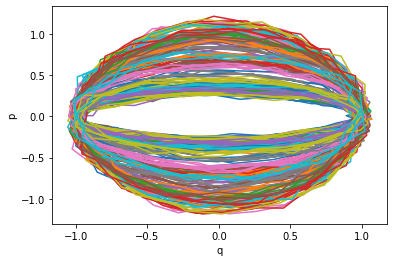

In [ ]:
# plot noisy pendulum data
for i in range(50):
  plt.plot(data['q_with_noies'][i],data['p_with_noies'][i])

plt.xlabel('q')
plt.ylabel('p');

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load training data
inputs  = torch.Tensor(data['data_in'])
outputs = torch.Tensor(data['qp_dot_with_noies'])

traindata  = TensorDataset(inputs, outputs)
dataloader = DataLoader(traindata, batch_size=256,shuffle=False, num_workers= 1)

## Load models

In [ ]:
# Initialize models

latent_dim = 3
aux_dim = 2
n_epochs = 500

# Initialize a baseline SciNet model

encoder = VAEncoder(input_dim = 100, # input trajectory length 50
                    latent_dim = 3, # output latent vector z
                    layer_dim = [500,100]) # ae layer dimensions, same as in SciNet

# In the Baseline we use a MLP as the neural analog function in our decoder
neural_analog_func_b = MLP(input_dim = latent_dim + aux_dim, # f(z,q,p)
                           hidden_dim   = 10, # layer dimensions
                           output_dim   = 2,  # output size 2 (qdot,pdot)
                           activation_func = nn.Tanh())

b_scinet_3lv03 = ConSciNet(Encoder = encoder, # VAE encoder 
                     NAFunc = neural_analog_func_b, # decoder: MLP
                     trial = f'Noise_lvl03_Baseline_{system}') # trial label


# Initialize a Constrained SciNet model

encoder = VAEncoder(input_dim = 100, # input trajectory length 50
                    latent_dim = latent_dim, # output latent vector z
                    layer_dim = [500,100]) # ae layer dimensions, same as in SciNet

diff_func = MLP(input_dim = latent_dim + aux_dim, # f(z,q,p)
                hidden_dim   = 10, # HNN layer dimensions
                output_dim   = 1,  # output size 1 H*
                activation_func = nn.Tanh())

# In the ConSciNet we use a modified HNN as the neural analog function in our decoder         
neural_analog_func = HNN(input_dim = 2, # number of canonical coordinates (q,p) input, the latent variables out put from the encoder are also received 
                         differentiable_model = diff_func
                         )

c_scinet_3lv03 = ConSciNet(Encoder = encoder, # VAE encoder
                     NAFunc = neural_analog_func, # decoder: HNN
                     trial = f'Noise_lvl03_ConSciNet_{system}') # trial label

In [ ]:
# load weights
load_model(b_scinet_3lv03,'models/weights/Noise_lvl03_Baseline_L_0308_pendulum_weights50k_lv3.pt')
load_model(c_scinet_3lv03,"models/weights/Noise_lvl03_ConSciNet_L_0308_pendulum_weights50k_lv3.pt")

<All keys matched successfully>

## Results

In [ ]:
def get_lv(model, z_dim):
    """
    Returns a vector of the latent variables for all input trajectories.
    Parameters:
    model: ConSciNet or Baseline model
    z_dim: number of latent variables 
    """
    z_list = []

    [z_list.append([]) for i in range(z_dim)]

    for i in range(data['x'].shape[0]):
      m = model.encoder(torch.tensor(data_in[i][:-2]).float()) #.detach().numpy()[0]
      latent_vec = model.encoder.mu.detach().numpy()
      [z_list[i].append(latent_vec[i]) for i in range(z_dim)]
    return z_list



In [ ]:
def integrate_model(model, t_span, y0, lv,**kwargs):
    """
    Evaluate a given model with an ODE solver
    Parameters:
    model: ConSciNet or Baseline model
    t_span: list of time interval [t_lower,t_upper]
    y0: y0
    lv: latent variables set to evaluate the decoder at
    """
      
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32) #.view(1,2)
        hnn_in = torch.cat([x.squeeze(),lv[0]])
        
        #[(latent,q,p), (q,p)]
        dx = model.nafunc.time_derivative(hnn_in,x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

### Predictions

In [ ]:
import pandas as pd

# select sequential values of lengths.
df = pd.DataFrame()
df['length'] = data['length']
df['trials'] = np.arange(len(data['length']))
df = df.sort_values(['length'])
df['key'] = np.arange(len(data['length']))

x = np.round(np.linspace(0,len(data['length']), 4))
x[3] = x[3] - 1
df = df[df['key'].isin(x)]
trial_vals = list(df['trials'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


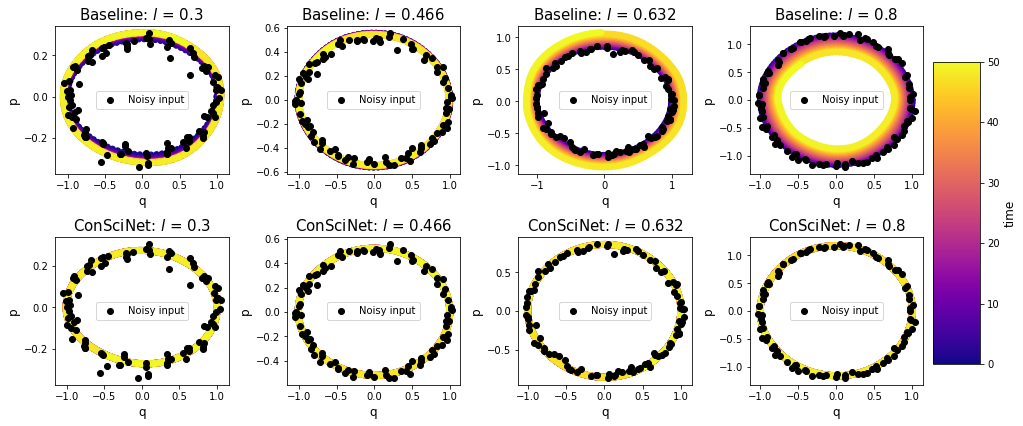

In [ ]:
# Evaluate the training data at selected length values and plot

share_axis = False
fig, axs = plt.subplots(2, len(trial_vals),figsize=(13,6), sharey= share_axis, sharex= share_axis)
t_span = [0,50]
n_points = 2000 # 100
c_model = c_scinet_3lv03
b_model =  b_scinet_3lv03
y0 = [1,0] # q,p
t_eval = np.linspace(t_span[0], t_span[1], n_points)
kwargs = {'t_eval': t_eval, 'rtol': 1e-12}

for trial_n in range(len(trial_vals)):

  trial = trial_vals[trial_n] #np.random.randint(1,49000)
  length = np.round(data['length'][trial],3)

  c_lv = c_model.encoder(torch.tensor(data_in[trial][:-2]).float())
  b_lv = b_model.encoder(torch.tensor(data_in[trial][:-2]).float())
  lv = c_lv
  c_path = integrate_model(c_model, t_span, y0, lv = c_lv, **kwargs)
  lv = b_lv
  b_path = integrate_model(b_model, t_span, y0,lv = b_lv, **kwargs)

  axs[1][trial_n].scatter(x = c_path['y'][0],y = c_path['y'][1], c = c_path['t'], cmap = 'plasma')
  c = axs[0][trial_n].scatter(x = b_path['y'][0],y = b_path['y'][1], c = b_path['t'], cmap = 'plasma')

  axs[1][trial_n].set_xlabel('q', fontsize = 12)
  axs[1][trial_n].set_ylabel('p', fontsize = 12)
  axs[1][trial_n].set_title(f'ConSciNet: $l$ = {length}', fontsize = 15)
  axs[1][trial_n].scatter(data['q_with_noies'][trial],data['p_with_noies'][trial], color = 'black', label = 'Noisy input')
  axs[1][trial_n].legend()

  axs[0][trial_n].set_xlabel('q', fontsize = 12)
  axs[0][trial_n].set_ylabel('p', fontsize = 12)
  axs[0][trial_n].set_title(f'Baseline: $l$ = {length} ', fontsize = 15);
  axs[0][trial_n].scatter(data['q_with_noies'][trial],data['p_with_noies'][trial], color = 'black', label = 'Noisy input')
  axs[0][trial_n].legend()

cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
fig.colorbar(c, cax=cbar_ax).set_label('time', fontsize = '12')
fig.tight_layout(pad=1.0);

### Latent variable disentanglement

In [ ]:
# get the latent vector for each model, returns [z_1,z_2,z_3] for each input trajectory
latent_vec_c3lv03 = get_lv(c_scinet_3lv03,z_dim = 3)
latent_vec_b3lv03 = get_lv(b_scinet_3lv03,z_dim = 3)

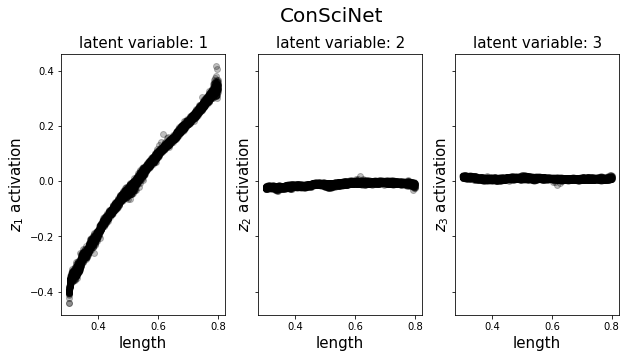

In [ ]:
# plot latent variables against underlying phyiscal parameter
z_list = latent_vec_c3lv03 
n_to_plot = 5000
fig,axs =  plt.subplots(1,len(z_list), sharey= True)

title = "ConSciNet" # pendulum latent vector disentanglement | $\sigma = 0.03$

for i in range(3):
  axs[i].scatter(data['length'][:n_to_plot],z_list[i][:n_to_plot], alpha = 0.25, color = 'black') #rasterized=True
  axs[i].set_title(f'latent variable: {i+1}', fontsize = 15)
  axs[i].set_xlabel('length', fontsize = 15)
  axs[i].set_ylabel(f'$z_{{{i+1}}}$ activation', fontsize = 15) 

fig.set_size_inches(10, 5)

fig.suptitle(title,fontsize = 20);
plt.subplots_adjust(top=0.85, wspace=0.2)

#plt.savefig('Pendulum_conscinet_lv_dis_v3.svg', format='svg',bbox_inches='tight', dpi = 300)
fig.show()

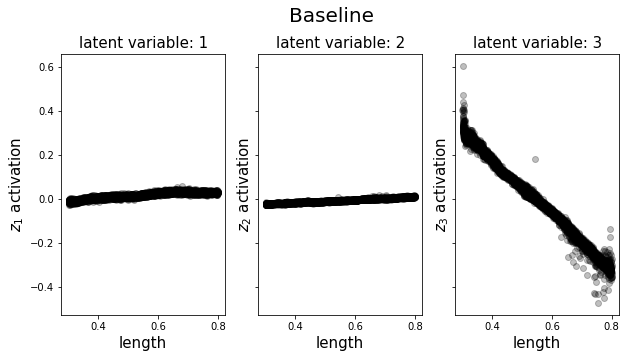

In [ ]:
z_list = latent_vec_b3lv03 
n_to_plot = 5000
fig,axs =  plt.subplots(1,len(z_list), sharey= True)

title = "Baseline" # pendulum latent vector disentanglement | $\sigma = 0.03$

for i in range(3):
  axs[i].scatter(data['length'][:n_to_plot],z_list[i][:n_to_plot], alpha = 0.25, color = 'black')
  axs[i].set_title(f'latent variable: {i+1}', fontsize = 15)
  axs[i].set_xlabel('length', fontsize = 15)
  axs[i].set_ylabel(f'$z_{{{i+1}}}$ activation', fontsize = 15) 

fig.set_size_inches(10, 5)

fig.suptitle(title,fontsize = 20);
fig.suptitle(title,fontsize = 20);
plt.subplots_adjust(top=0.85, wspace=0.2)

#plt.savefig('Pendulum_baseline_lv_dis_v3.svg', format='svg',bbox_inches='tight', dpi = 300)
fig.show()

### Interpolation


In [ ]:
def evaluate_model(latent_vec = None,lv_pos = None,model = 'gt', data = data, n = 5, y0 = [1,0], t_span = [0,10], poly_order = 3):
    """
    Evaluate a model or ground truth at a number of interpolated latent variables.
    Parameters:
    latent_vec: latent variable vector obtained with get_lv()
    lv_pos: position of the latent variable encoding a physical parameter like value
    model: a ConSciNet or Baseline model or the string 'gt' for ground truth evaluation
    n: number to interpolate
    y0: y0
    t_span: list of time interval [t_lower,t_upper]
    poly_order: order of polynomial to fit between the latent variable and ground truth parameters
    """
    
    # ODE args
    t_eval = np.linspace(t_span[0], t_span[1], 2000)
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}

    #get postion of min max in training data
    in_length = data['length']
    len_min_idx = np.argmin(in_length)
    len_max_idx = np.argmax(in_length)
    min_input = data['x'][len_min_idx]
    max_input = data['x'][len_max_idx]

    # interpolate between min and max gt length
    l_vals = np.linspace(np.min(in_length), np.max(in_length), n) 

    if model == 'gt':
      #ground truth
      gt_paths = []
      for l in l_vals:
        pen_params['l'] = l
        gt_path = solve_ivp(fun=dynamics_fn, 
                                t_span=t_span, 
                                y0=y0, 
                                t_eval=t_eval, 
                                rtol=1e-12)
        gt_paths.append(gt_path)
      return gt_paths

    
    # map gt length values to length like parameter
    lv_fit = np.poly1d(np.polyfit(data['length'],latent_vec[lv_pos], deg = poly_order))

    # get length like values to evaluate model
    l_like_vals = lv_fit(l_vals)

    pred_paths = []

    for lv in l_like_vals:
      pred = []
      lv_values = np.zeros(model.encoder.latent_dim)
      lv_values[lv_pos] = lv  #  e.g. [0,lv,0]
      lv_values = list(lv_values)
      lv = torch.tensor([lv_values]).float()
      pred_paths.append(integrate_model(model, t_span, y0,lv = lv, **kwargs))

    return pred_paths


In [ ]:
# evaluate models over t-span = [0,20]

t_span = [0,20]
n_interp = 4
poly_order = 3

conscinet_eval = evaluate_model(model =  c_scinet_3lv03,
                                latent_vec = latent_vec_c3lv03,
                                lv_pos = 0,
                                n = n_interp, 
                                t_span = t_span,
                                poly_order = poly_order)

baseline_eval = evaluate_model(model =  b_scinet_3lv03,
                                latent_vec = latent_vec_b3lv03,
                                lv_pos = 2,
                                n = n_interp, 
                                t_span = t_span,
                                poly_order = poly_order)


gt_eval = evaluate_model(model =  'gt',
                                n = n_interp, 
                                t_span = t_span,
                                poly_order = poly_order)

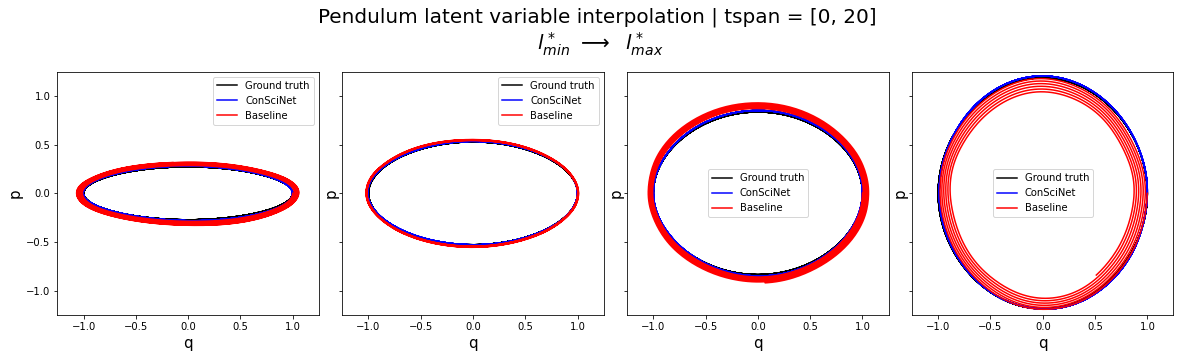

In [ ]:
#phase plot
fig, axs = plt.subplots(1, n_interp,figsize=(20,5), sharey= True, sharex = True)
for i in range(n_interp):
  axs[i].plot(gt_eval[i]['y'][0], gt_eval[i]['y'][1], color = 'black', label = 'Ground truth')
  axs[i].plot(conscinet_eval [i]['y'][0],conscinet_eval [i]['y'][1], color = 'blue', label = 'ConSciNet')
  axs[i].plot(baseline_eval[i]['y'][0],baseline_eval[i]['y'][1], color = 'red',label = 'Baseline')

  axs[i].set_ylabel('p', fontsize = 15)
  axs[i].set_xlabel('q', fontsize = 15)
  axs[i].legend(loc = 'best')
  
plt.setp(axs, xlim= [-1.25, 1.25])
plt.setp(axs, ylim= [-1.25, 1.25])
plt.subplots_adjust(top=0.8, wspace=0.09)
plt_title = f'Pendulum latent variable interpolation | tspan = {t_span}' + '\n $l_{min}^*$ $\longrightarrow$  $l_{max}^*$'

fig.suptitle(plt_title, fontsize = 20);
#plt.savefig('Pendulum_ConSciNet_Phase.svg', format='svg',bbox_inches='tight', dpi = 300)

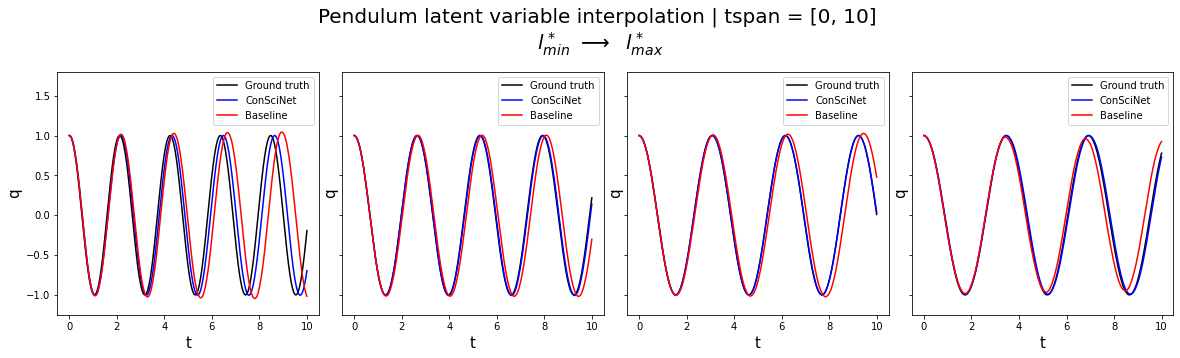

In [ ]:
# evaluate models over t-span = [0,10]

t_span = [0,10]
n_interp = 4
poly_order = 3

conscinet_eval = evaluate_model(model =  c_scinet_3lv03,
                                latent_vec = latent_vec_c3lv03,
                                lv_pos = 0,
                                n = n_interp, 
                                t_span = t_span,
                                poly_order = poly_order)

baseline_eval = evaluate_model(model =  b_scinet_3lv03,
                                latent_vec = latent_vec_b3lv03,
                                lv_pos = 2,
                                n = 4, 
                                t_span = t_span,
                                poly_order = poly_order)

gt_eval = evaluate_model(model =  'gt',
                                n = 4, 
                                t_span = t_span,
                                poly_order = poly_order)

#time plot
t_eval = np.linspace(t_span[0], t_span[1], 2000)
fig, axs = plt.subplots(1, n_interp,figsize=(20,5), sharey= True, sharex = True)
for i in range(n_interp):
  axs[i].plot(t_eval, gt_eval[i]['y'][0], color = 'black', label = 'Ground truth')
  axs[i].plot(t_eval,conscinet_eval[i]['y'][0], color = 'blue', label = 'ConSciNet')
  axs[i].plot(t_eval,baseline_eval[i]['y'][0], color = 'red',label = 'Baseline')
  axs[i].set_ylabel('q', fontsize = 15)
  axs[i].set_xlabel('t', fontsize = 15)
  axs[i].legend(loc = 'best')

plt.setp(axs, ylim= [-1.25, 1.8])
plt.subplots_adjust(top=0.8, wspace=0.09)
plt_title = f'Pendulum latent variable interpolation | tspan = {t_span}' + '\n $l_{min}^*$ $\longrightarrow$  $l_{max}^*$'

fig.suptitle(plt_title, fontsize = 20);
#plt.savefig('Pendulum_ConSciNet_time.svg', format='svg',bbox_inches='tight', dpi = 300)


#### MSE

In [ ]:
conscinet_mse = [np.mean(np.square(gt_eval[i]['y'] - conscinet_eval[i]['y'])) for i in range(n_interp)]
baseline_mse =  [np.mean(np.square(gt_eval[i]['y'] - baseline_eval[i]['y']))  for i in range(n_interp)]

length_vals = np.round(np.linspace(0.3, 0.8, n_interp),1)
mse_df = pd.DataFrame()
mse_df['length'] = length_vals
mse_df['Baseline MSE'] = baseline_mse
mse_df['ConSciNet MSE'] = conscinet_mse
mse_df
#mse_df.to_latex()

,length,Baseline MSE,ConSciNet MSE
0,0.3,0.164810,0.028662
1,0.5,0.022914,0.000582
2,0.6,0.022449,0.000123
3,0.8,0.025539,0.001482
